In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler as SS
from statsmodels.stats.multitest import fdrcorrection
from matplotlib import rc

rc('text', usetex=False)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2,
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [2]:
df = pd.read_csv('log_ap_df.csv').rename(columns={'Unnamed: 0': 'gene'}).set_index('gene')
# tub1 is effed up, so lets kill it
# con1 is effed up, kill it
wanted = [c for c in df.columns if ('tub1' not in c) & ('con1' not in c)]
df = df[wanted]
df = df[(df > 0.5).sum(axis=1) > 5]
df.head()

,con2A,con2P,con4A,con4P,con5A,con5P,tub2A,tub2P,tub3A,tub3P,tub4A,tub4P,tub5A,tub5P
gene,,,,,,,,,,,,,,
SteCoe_1,4.862229,5.083837,5.067023,4.794471,5.159237,4.678247,4.948243,4.704319,4.446902,4.385588,4.280728,4.336849,4.387184,4.150624
SteCoe_10,3.310267,3.557339,3.392957,3.338245,3.079831,3.272346,3.250539,3.426690,3.275349,3.249149,3.441771,3.629246,3.616664,3.561797
SteCoe_100,0.448487,0.950953,0.798218,0.658658,0.697524,0.677687,0.821407,1.071005,1.042232,0.805663,0.996761,0.724791,0.872272,0.880112
SteCoe_1000,3.210635,3.615015,3.176114,3.390179,3.381500,3.083633,3.921269,3.952004,3.869610,4.036804,4.077154,3.725640,3.637402,3.677309
SteCoe_10002,2.642902,3.197424,3.453061,3.314831,3.312158,3.207587,2.994912,3.360969,3.365353,3.120192,3.477802,3.389040,3.553889,3.819785


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

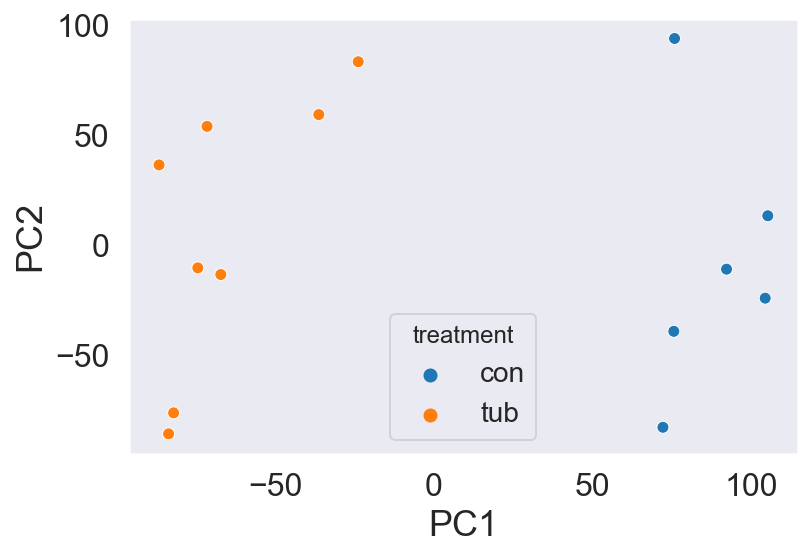

In [3]:
# compute a nice pca:
pca = PCA(2)
# SS().fit_transform scales the data so mean per gene is 0, and std per gene = 1
# pca.fit_transform computes pca to 2 components
coords = pca.fit_transform(SS().fit_transform(df.T))
# get coordinates into a nice dataframe
pc = pd.DataFrame(coords, index=df.columns, columns=['PC1', 'PC2'])
# annotate metadata:
pc['treatment'] = pd.Series(pc.index).astype(str).str[:3].values
pc['polarity'] = pd.Series(pc.index).astype(str).str[-1].values
sns.scatterplot('PC1', 'PC2', hue='treatment', data=pc)

/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

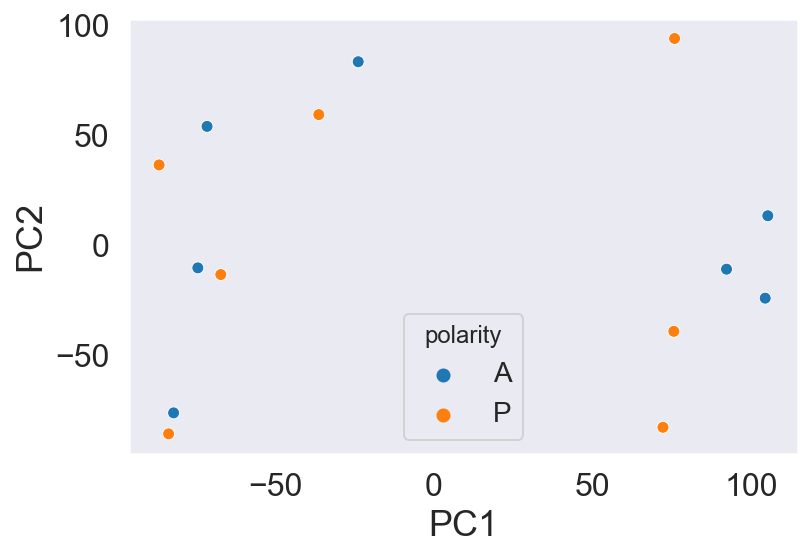

In [4]:
sns.scatterplot('PC1', 'PC2', hue='polarity', data=pc)

/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


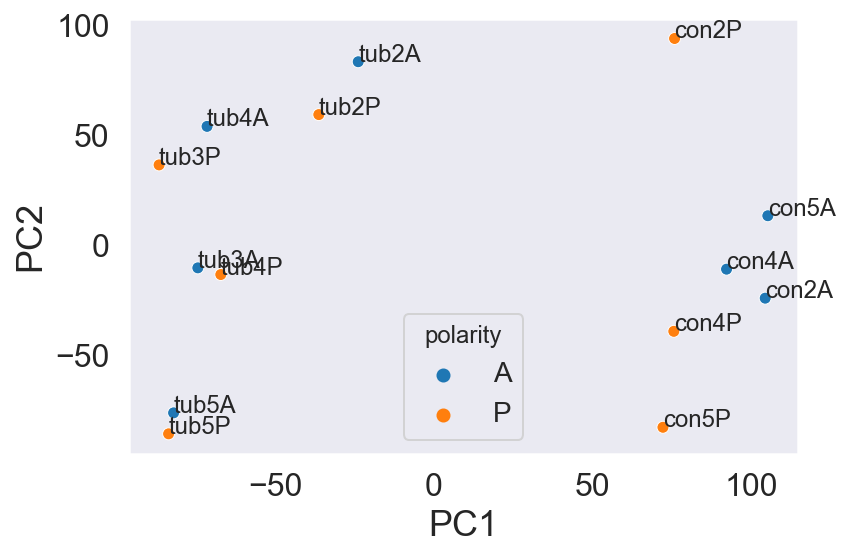

In [5]:
sns.scatterplot('PC1', 'PC2', hue='polarity', data=pc)
for sample in pc.index:
    s = pc.reindex([sample])
    plt.annotate(sample, (s.PC1, s.PC2))

In [6]:
# cast the dataframe from matrix shape into tidy format
tidy = df.reset_index()\
         .melt(id_vars='gene', var_name='Sample', value_name='log1TPM') 
# annotate metadata:
tidy['treatment'] = tidy.Sample.str[:3]
tidy['Cell_ID'] = tidy.Sample.str[:4]
tidy['Polarity'] = tidy.Sample.str[-1]
tidy.head()

,gene,Sample,log1TPM,treatment,Cell_ID,Polarity
0,SteCoe_1,con2A,4.862229,con,con2,A
1,SteCoe_10,con2A,3.310267,con,con2,A
2,SteCoe_100,con2A,0.448487,con,con2,A
3,SteCoe_1000,con2A,3.210635,con,con2,A
4,SteCoe_10002,con2A,2.642902,con,con2,A


In [7]:
# compute mean log1TPM per sample
tidy['sample_mean_log1TPM'] = tidy.groupby('Sample').log1TPM.transform(np.mean).values
# compute a "regularized" log1TPM, which is equal to log1TPM + mean log1TPM for that sample
tidy['log1RPM'] = tidy.log1TPM + tidy.sample_mean_log1TPM
tidy.head()

,gene,Sample,log1TPM,treatment,Cell_ID,Polarity,sample_mean_log1TPM,log1RPM
0,SteCoe_1,con2A,4.862229,con,con2,A,2.046958,6.909187
1,SteCoe_10,con2A,3.310267,con,con2,A,2.046958,5.357225
2,SteCoe_100,con2A,0.448487,con,con2,A,2.046958,2.495445
3,SteCoe_1000,con2A,3.210635,con,con2,A,2.046958,5.257593
4,SteCoe_10002,con2A,2.642902,con,con2,A,2.046958,4.689860


In [8]:
# split tidy dataframe into two, A and P dataframes
atidy = tidy[tidy.Polarity == 'A'].set_index(['gene', 'Cell_ID'])
ptidy = tidy[tidy.Polarity == 'P'].set_index(['gene', 'Cell_ID'])

# stack the two tidy dataframes so that A and P from the same cell are side by side
stack = atidy.join(ptidy[['log1RPM', 'sample_mean_log1TPM']], rsuffix=('_posterior'))
stack.head()

,,Sample,log1TPM,treatment,Polarity,sample_mean_log1TPM,log1RPM,log1RPM_posterior,sample_mean_log1TPM_posterior
gene,Cell_ID,,,,,,,,
SteCoe_1,con2,con2A,4.862229,con,A,2.046958,6.909187,7.113079,2.029242
SteCoe_10,con2,con2A,3.310267,con,A,2.046958,5.357225,5.586581,2.029242
SteCoe_100,con2,con2A,0.448487,con,A,2.046958,2.495445,2.980195,2.029242
SteCoe_1000,con2,con2A,3.210635,con,A,2.046958,5.257593,5.644257,2.029242
SteCoe_10002,con2,con2A,2.642902,con,A,2.046958,4.689860,5.226666,2.029242


In [9]:
# compute skew as regularized Delta / regularized Total counts
stack['Skew'] = ((stack.log1RPM - stack.log1RPM_posterior) /
                 (stack.log1RPM + stack.log1RPM_posterior))
stack.head()

,,Sample,log1TPM,treatment,Polarity,sample_mean_log1TPM,log1RPM,log1RPM_posterior,sample_mean_log1TPM_posterior,Skew
gene,Cell_ID,,,,,,,,,
SteCoe_1,con2,con2A,4.862229,con,A,2.046958,6.909187,7.113079,2.029242,-0.014541
SteCoe_10,con2,con2A,3.310267,con,A,2.046958,5.357225,5.586581,2.029242,-0.020958
SteCoe_100,con2,con2A,0.448487,con,A,2.046958,2.495445,2.980195,2.029242,-0.088528
SteCoe_1000,con2,con2A,3.210635,con,A,2.046958,5.257593,5.644257,2.029242,-0.035468
SteCoe_10002,con2,con2A,2.642902,con,A,2.046958,4.689860,5.226666,2.029242,-0.054133


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Skew', ylabel='Density'>

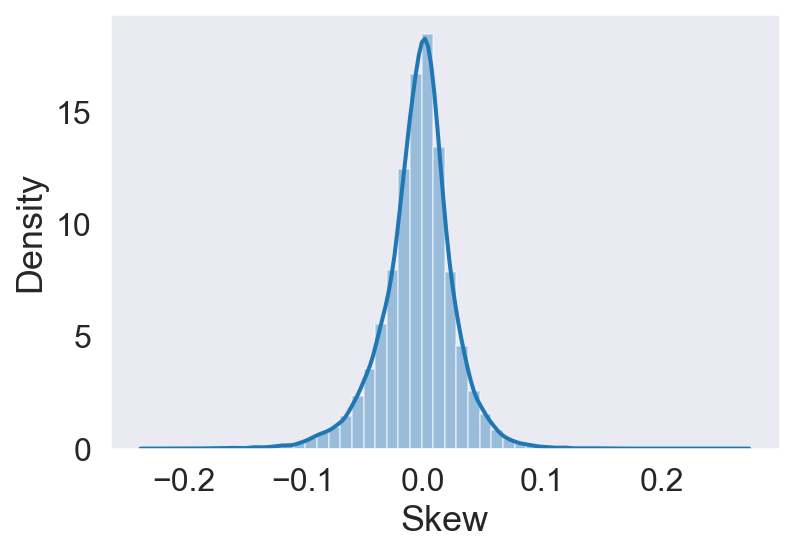

In [10]:
# visualize a histogram of mean skews.
mean_skews = stack.reset_index()\
                  .groupby(['treatment', 'gene'])['log1RPM', 'log1RPM_posterior', 'Skew']\
                  .mean()\
                  .reset_index()

mean_skews['mean_log1RPM'] = (mean_skews.log1RPM + mean_skews.log1RPM_posterior) / 2
sns.distplot(mean_skews[mean_skews.treatment == 'con'].Skew)

/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Skew', ylabel='Density'>

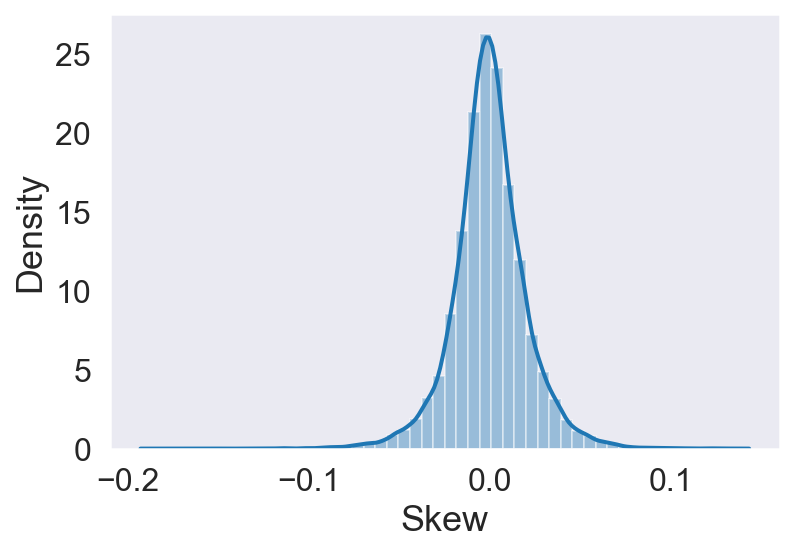

In [11]:
sns.distplot(mean_skews[mean_skews.treatment == 'tub'].Skew)

Text(0.5, 1.0, 'Skew')

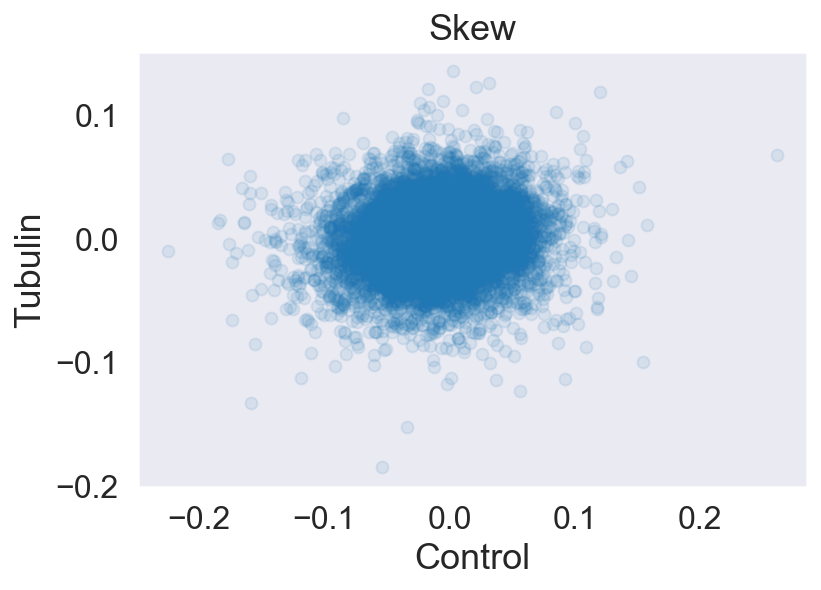

In [12]:
# plot mean skews in control vs tubulin
cond = lambda x: mean_skews.treatment == x
plt.scatter(mean_skews[cond('con')].Skew, mean_skews[cond('tub')].Skew, alpha=0.1)

plt.xlabel('Control')
plt.ylabel('Tubulin')
plt.title('Skew')

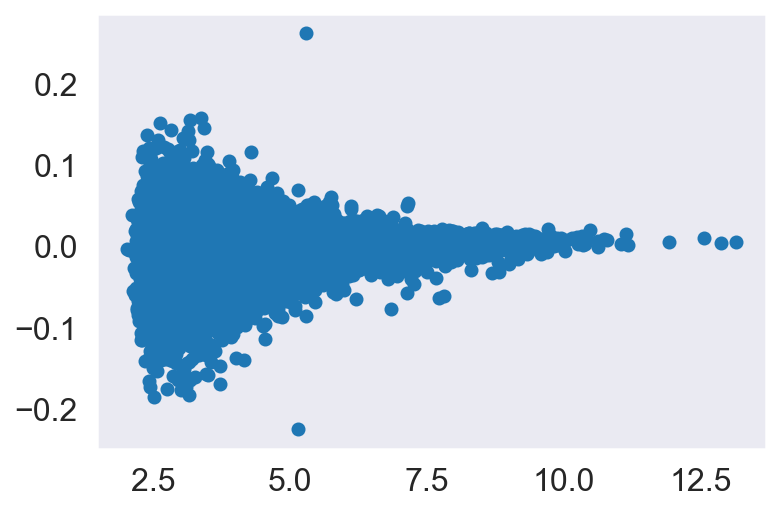

In [13]:
# mean vs skew plots
plt.scatter(mean_skews[cond('con')].mean_log1RPM, mean_skews[cond('con')].Skew)

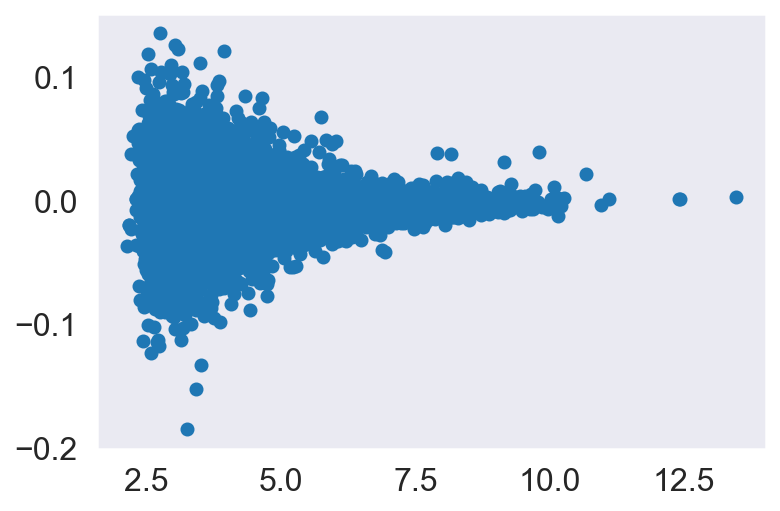

In [14]:
plt.scatter(mean_skews[cond('tub')].mean_log1RPM, mean_skews[cond('tub')].Skew)

25322


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

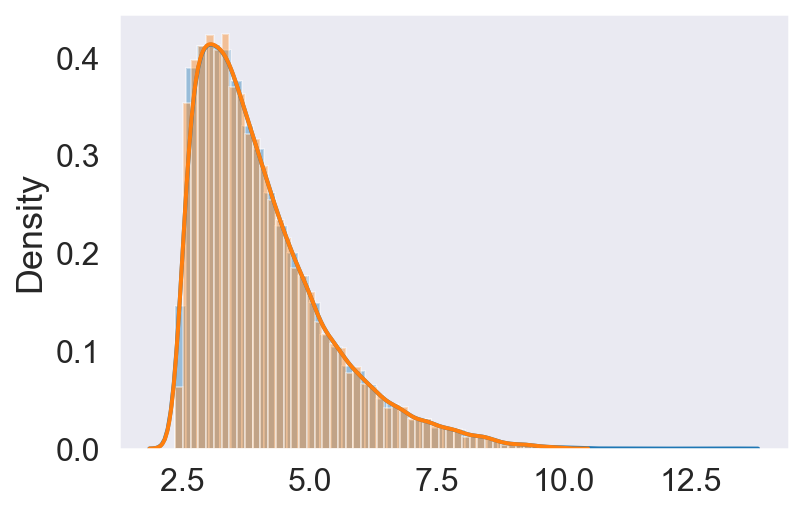

In [15]:
# make sure RPMs are within a reasonable range:
mean_rpm = stack.groupby('gene')[['log1RPM_posterior', 'log1RPM']].mean().mean(axis=1)
wanted = mean_rpm[mean_rpm.between(2, 10)].index
print(len(wanted))
sns.distplot(mean_rpm)
sns.distplot(mean_rpm[mean_rpm.between(2, 10)])

In [16]:
# compute a fano factor (std / mean) so we don't test things that are
# so variable that they would never be stat sig differentially expressed
# therefore reducing our FDR penalty
stack = stack.reset_index()[stack.reset_index().gene.isin(wanted)]
stack['fano_factor'] = stack.groupby(['gene', 'treatment']).Skew\
                            .transform(lambda x: np.std(x) / np.abs(np.mean(x)))
stack.sort_values(['gene', 'Cell_ID'], inplace=True)
stack.head()

,gene,Cell_ID,Sample,log1TPM,treatment,Polarity,sample_mean_log1TPM,log1RPM,log1RPM_posterior,sample_mean_log1TPM_posterior,Skew,fano_factor
0,SteCoe_1,con2,con2A,4.862229,con,A,2.046958,6.909187,7.113079,2.029242,-0.014541,1.618032
25339,SteCoe_1,con4,con4A,5.067023,con,A,2.005359,7.072382,6.803104,2.008634,0.019407,1.618032
50678,SteCoe_1,con5,con5A,5.159237,con,A,2.006640,7.165877,6.736237,2.057990,0.030905,1.618032
76017,SteCoe_1,tub2,tub2A,4.948243,tub,A,2.050640,6.998883,6.747187,2.042867,0.018310,1.051115
101356,SteCoe_1,tub3,tub3A,4.446902,tub,A,2.052930,6.499831,6.437725,2.052137,0.004800,1.051115


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'log(Fano Factor)')

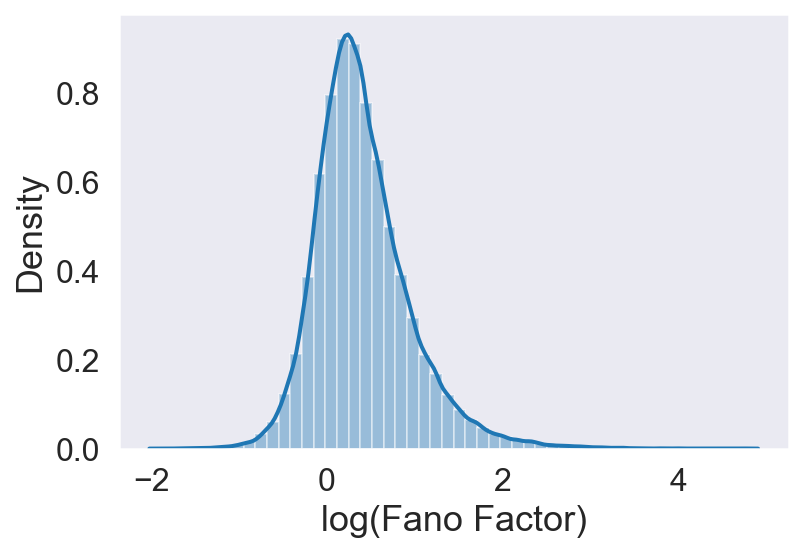

In [17]:
sns.distplot(stack.fano_factor.apply(np.log10))
plt.xlabel('log(Fano Factor)')

In [18]:
# remove genes where the fano factor is >3. 
stack = stack[stack.fano_factor < 2]
# find genes that are present in tub and control, cause the above line may have broken that
sel = (stack.groupby('gene').treatment.count() == 7)
wanted = stack.groupby('gene').treatment.count()[sel].index
stack = stack[stack.gene.isin(wanted)]
len(stack.gene.unique())

5853

/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


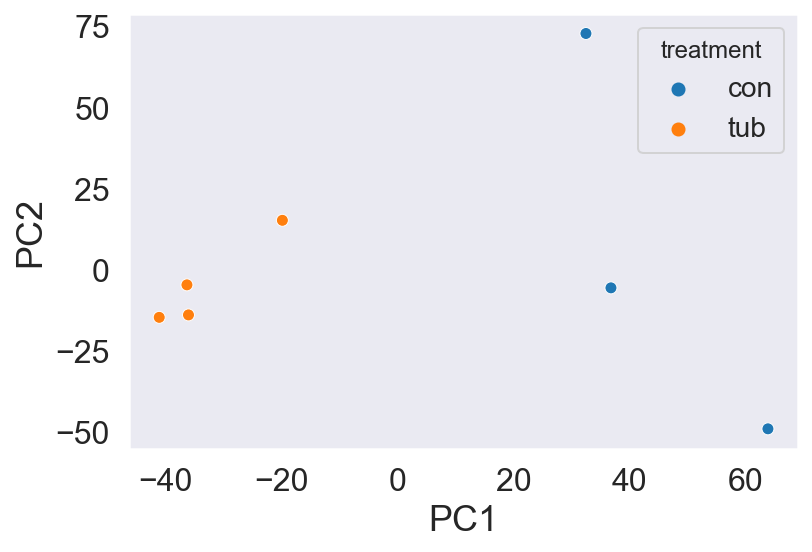

In [19]:
# next, use PCA to select genes that are likely to have a sig skew value so that we only test those
x = stack.pivot(index='gene', columns='Sample', values='Skew')

pca = PCA(2)
coords = pca.fit_transform(SS().fit_transform(x.T))
pc = pd.DataFrame(coords, index=x.columns, columns=['PC1', 'PC2'])
pc['treatment'] = pd.Series(pc.index).astype(str).str[:3].values
pc['polarity'] = pd.Series(pc.index).astype(str).str[-1].values
sns.scatterplot('PC1', 'PC2', hue='treatment', data=pc)
wanted = x.index[np.argsort(np.abs(pca.components_[0]))[-500:]]

stack = stack[stack.gene.isin(wanted)]

In [20]:
# do a t-test for statistical significance
PV = []
G = []
for gene, group in stack.reset_index()[stack.reset_index().gene.isin(wanted)].groupby('gene'):
    npolar = group[group.treatment == 'tub'].Skew
    polar = group[group.treatment == 'con'].Skew
    t, p = scipy.stats.ttest_ind(npolar, polar, equal_var=False)
    PV += [p]
    G += [gene]
    
# store results in a dataframe:
pvals = pd.DataFrame([PV, G], index=['p_value', 'gene']).T.set_index('gene')
pvals['q_value'] = fdrcorrection(pvals.p_value.values)[1]
pvals['sig'] = (pvals.q_value < 0.1).values
pvals.head()

,p_value,q_value,sig
gene,,,
SteCoe_10036,0.0675403,0.09433,True
SteCoe_10062,0.0356142,0.0738065,True
SteCoe_10386,0.109563,0.12369,False
SteCoe_10500,0.0318864,0.0707138,True
SteCoe_1084,0.0609282,0.0888875,True


In [21]:
pvals.sort_values('p_value')

,p_value,q_value,sig
gene,,,
SteCoe_27397,0.000112595,0.0237857,True
SteCoe_24733,0.000127639,0.0237857,True
SteCoe_33586,0.000153672,0.0237857,True
SteCoe_20522,0.000190286,0.0237857,True
SteCoe_2417,0.000325698,0.0325698,True
...,...,...,...
SteCoe_26389,0.193034,0.194591,False
SteCoe_10919,0.195587,0.196768,False
SteCoe_2888,0.20933,0.210171,False


In [22]:
# number of DE genes at alpha < 0.1
pvals.sig.sum()

382

In [23]:
# append results to our master "stack" dataframe:
stack = stack.join(pvals, on='gene')

/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Skew')

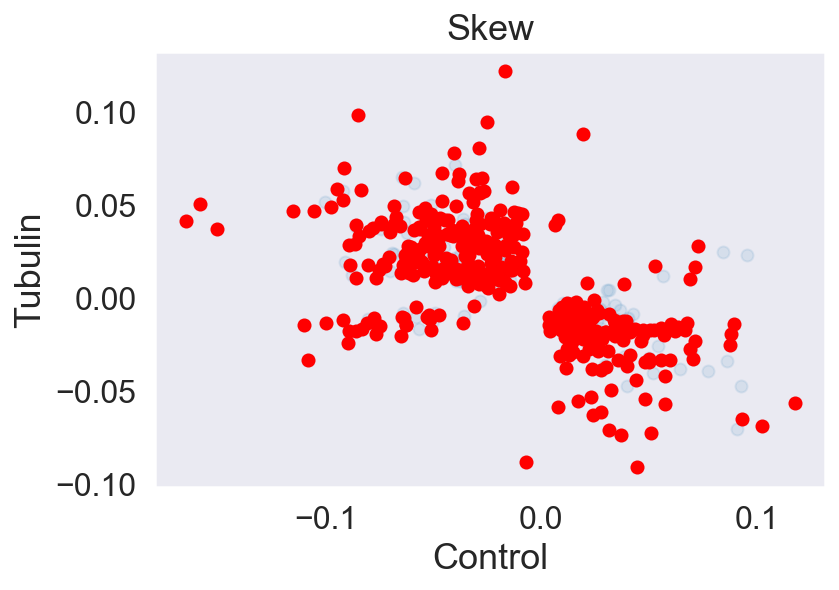

In [24]:
# recompute mean skews
mean_skews = stack\
                  .groupby(['treatment', 'gene'])['log1RPM', 'log1RPM_posterior', 'Skew']\
                  .mean()\
                  .reset_index()
mean_skews = mean_skews.join(pvals.sig, on='gene')

cond = lambda x: (mean_skews.treatment == x)
mean_skews['mean_log1RPM'] = (mean_skews.log1RPM + mean_skews.log1RPM_posterior) / 2


# plot tubulin vs control skews. Now the plot will not look like an oval,
# mainly because we removed lots of things that were low expression, or that had
# poor fano factors
plt.scatter(mean_skews[cond('con')].Skew, mean_skews[cond('tub')].Skew, alpha=0.1)
plt.scatter(mean_skews[cond('con') & (mean_skews.sig == True)].Skew,
            mean_skews[cond('tub') & (mean_skews.sig == True)].Skew, color='red')
plt.xlabel('Control')
plt.ylabel('Tubulin')
plt.title('Skew')

# the plot below looks like a butterfly
# the correlated arm are likely genes where the KD did not have
# a strong effect on rna localization
# the anticorrelated arm are genes that switched their localization
# upon KD of tubulin

In [25]:
# most interesting genes are likely anticorrelated
# switch the mean_skews matrix from tidy format into matrix format,
# where genes are rows, and there are two columns, control and treatment
skew_mat = mean_skews.pivot(index='gene', columns='treatment', values='Skew')
# select things that are anticorrelated
#(anticorrelated genes have opposing signs) in tubulin and control
anticorr = skew_mat[skew_mat.con * skew_mat.tub < 0].index

# select anticorrelated genes between tub and control, that are sig in qval
# and for tidyness select just controls
select = ((mean_skews.gene.isin(anticorr)) &
          (mean_skews.sig) &
          (mean_skews.treatment == 'con'))
        
mean_skews[select].sort_values('Skew')

,treatment,gene,log1RPM,log1RPM_posterior,Skew,sig,mean_log1RPM
375,con,SteCoe_35013,2.019652,2.821557,-0.165133,True,2.420604
11,con,SteCoe_11319,2.960104,4.039403,-0.158769,True,3.499753
386,con,SteCoe_36057,2.601449,3.519104,-0.150664,True,3.060276
248,con,SteCoe_26054,2.019652,2.560736,-0.115558,True,2.290194
479,con,SteCoe_9126,2.780742,3.433139,-0.105791,True,3.106940
...,...,...,...,...,...,...,...
385,con,SteCoe_35890,3.643706,3.069293,0.088087,True,3.356499
102,con,SteCoe_16525,3.127036,2.605478,0.089524,True,2.866257
21,con,SteCoe_11625,4.324349,3.601348,0.093127,True,3.962848
398,con,SteCoe_37198,3.019476,2.465037,0.102744,True,2.742256


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='mean_log1RPM', ylabel='Skew'>

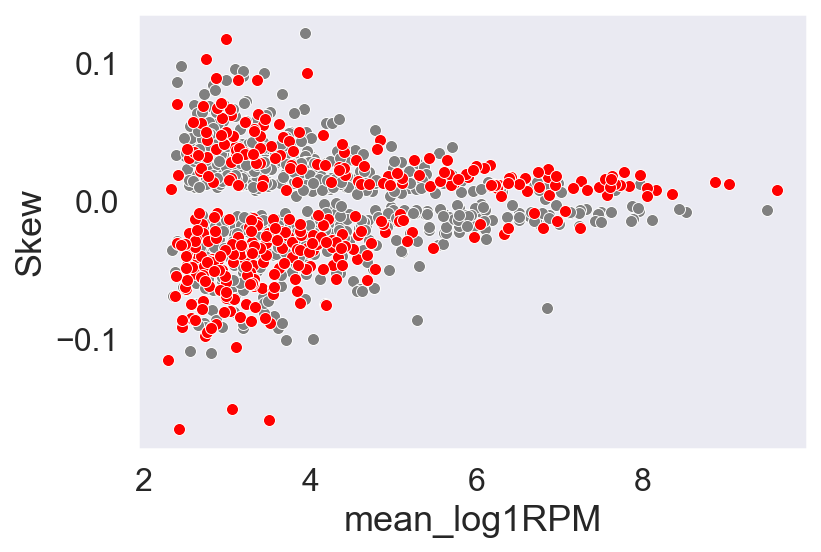

In [26]:
# MA plot showing how low or high regularized expression these genes have:
sns.scatterplot('mean_log1RPM', 'Skew', data=mean_skews, color='gray')
sns.scatterplot('mean_log1RPM', 'Skew', data=mean_skews[select], color='red')


In [27]:
# compute the transcriptome wide skew per sample:
avg_skew = ((stack.sample_mean_log1TPM - stack.sample_mean_log1TPM_posterior) /
            (stack.sample_mean_log1TPM + stack.sample_mean_log1TPM_posterior))
stack['avg_skew_treatment'] = avg_skew

/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='treatment', ylabel='avg_skew_treatment'>

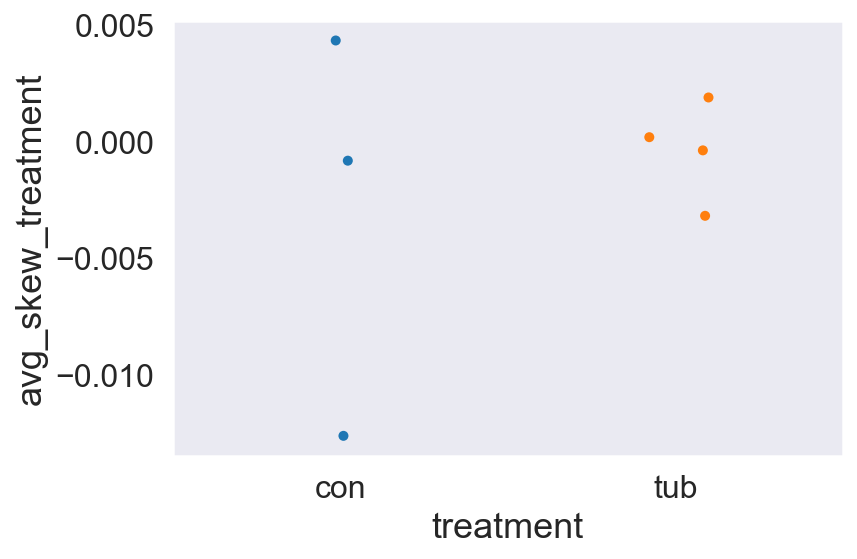

In [28]:
# for each sample, plot the transcriptome-wide skew:
sns.stripplot('treatment', 'avg_skew_treatment',
              data=stack[['treatment', 'avg_skew_treatment']].drop_duplicates())

In [29]:
# compute the mean transcriptome-wide skews for control and tubulin
# and then compute the difference of means between both conditions
# this is the smallest believable "skew"
stack[['treatment', 'avg_skew_treatment']]\
    .drop_duplicates()\
    .groupby('treatment')\
    .mean()\
    .diff()\
    .dropna()

,avg_skew_treatment
treatment,
tub,0.002668


In [30]:
# the above line tells you what difference is probably the smallest difference
# you should ever believe in skew

In [31]:
# all samples have Skews > 0.0027, but let's make sure anyways
mean_skews[(select) & (mean_skews.Skew.abs() > 0.0027)].sort_values('Skew')

,treatment,gene,log1RPM,log1RPM_posterior,Skew,sig,mean_log1RPM
375,con,SteCoe_35013,2.019652,2.821557,-0.165133,True,2.420604
11,con,SteCoe_11319,2.960104,4.039403,-0.158769,True,3.499753
386,con,SteCoe_36057,2.601449,3.519104,-0.150664,True,3.060276
248,con,SteCoe_26054,2.019652,2.560736,-0.115558,True,2.290194
479,con,SteCoe_9126,2.780742,3.433139,-0.105791,True,3.106940
...,...,...,...,...,...,...,...
385,con,SteCoe_35890,3.643706,3.069293,0.088087,True,3.356499
102,con,SteCoe_16525,3.127036,2.605478,0.089524,True,2.866257
21,con,SteCoe_11625,4.324349,3.601348,0.093127,True,3.962848
398,con,SteCoe_37198,3.019476,2.465037,0.102744,True,2.742256


In [32]:
x = []
y = []
with open('S_coeruleus_Nov2017_proteins.fasta') as f:
    lines = f.readlines()
    for l in lines:
        if '>' in l:
            line = l.split('\t')
            gene = line[0][1:]
            domain = line[1].strip()
            x += [gene]
            y += [domain]

prot_data = pd.DataFrame([x, y], index=['gene', 'domain']).T.set_index('gene')

In [33]:
mean_skews = mean_skews.join(prot_data, on='gene')

In [34]:
mean_skews[(select) & (mean_skews.Skew.abs() > 0.0027)].sort_values('Skew').tail(20)

,treatment,gene,log1RPM,log1RPM_posterior,Skew,sig,mean_log1RPM,domain
65,con,SteCoe_14610,3.625750,3.229900,0.055390,True,3.427825,CK_II_beta domain protein
433,con,SteCoe_4636,3.813916,3.423070,0.055607,True,3.618493,MAT1 domain protein
41,con,SteCoe_1329,2.837291,2.528796,0.057000,True,2.683043,RIH_assoc domain protein
194,con,SteCoe_22530,3.394927,3.031318,0.057351,True,3.213123,TPR_2 domain protein
482,con,SteCoe_9244,2.740104,2.437295,0.057389,True,2.588700,hypothetical protein
307,con,SteCoe_2990,3.664883,3.250722,0.059819,True,3.457803,STE related kinase
132,con,SteCoe_18022,3.111519,2.757921,0.060205,True,2.934720,hypothetical protein
98,con,SteCoe_164,3.243746,2.858364,0.062174,True,3.051055,AMPK subfamily kinase
300,con,SteCoe_29318,3.587100,3.154658,0.063389,True,3.370879,hypothetical protein
327,con,SteCoe_31769,3.243462,2.836166,0.066659,True,3.039814,kinase related to Ciliate-E2-Unclassified subf...
